# BenchFS IOR Result Visualizer (Miyabi)

`results/benchfs/*/ior_results/ior_result_*.json` から IOR のサマリ JSON を読み込み、操作別の帯域やレイテンシを可視化します。

Miyabi用: ノード数は `job_metadata_{runid}.json` から取得します。

In [1]:
from pathlib import Path
import json
import re

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# 手動で実験を指定する場合はここを編集
SELECTED_EXPERIMENTS: list[str] | None = ["2025.12.01-03.54.40-large_scale_cppn"]  # 最新の実験を自動選択

# Plot style configuration
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
})
pl.Config.set_tbl_rows(100)

DATA_DIR = (Path.cwd() / "processed" / "benchfsd").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = (Path.cwd() / "fig" / "benchfsd").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(fig, name: str) -> None:
    for ext in ("png", "pdf"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight", dpi=150)

def comma_formatter(value, _):
    return f"{value:,.0f}"

def slugify(value: str) -> str:
    cleaned = re.sub(r"[^A-Za-z0-9._-]+", "_", value)
    return cleaned.strip("_") or "unknown"

In [2]:
def resolve_results_root() -> Path:
    candidates = [
        Path("results"),
        Path("..") / "results",
        Path("../..") / "results",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError("results ディレクトリが見つかりません。ノートブックの位置を確認してください。")

results_root = resolve_results_root()
print(f"Using results directory: {results_root}")

Using results directory: /work/xg24i002/x10043/workspace/rust/benchfs/results


In [3]:
def fix_ior_json(content: str) -> str:
    """Fix common IOR JSON output format bugs.
    
    IOR 4.0.0 has several JSON formatting issues:
    1. Double closing brackets after Results array: ]] -> ]
    2. Extra closing bracket at the end of tests array
    3. Trailing commas before closing braces/brackets
    """
    # Issue 1: Double closing bracket after Results array
    content = re.sub(r'\]\s*\]\s*,\s*"max":', r'], "max":', content)
    
    # Issue 2: Extra closing bracket at the end of tests array  
    content = re.sub(r'\}\s*\]\s*\]\s*,\s*"summary":', r'}], "summary":', content)
    
    # Issue 3: Trailing comma before closing brace
    content = re.sub(r',\s*\}', '}', content)
    
    # Issue 4: Trailing comma before closing bracket
    content = re.sub(r',\s*\]', ']', content)
    
    return content

def safe_load_json(path: Path) -> dict | None:
    """Load JSON file with automatic fix for IOR format issues."""
    try:
        content = path.read_text()
        # Try parsing as-is first
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            pass
        # Apply fixes and retry
        fixed_content = fix_ior_json(content)
        return json.loads(fixed_content)
    except (OSError, json.JSONDecodeError) as exc:
        print(f"Warning: Failed to parse {path}: {exc}")
        return None

In [4]:
def load_job_metadata(run_dir: Path, run_index: int) -> dict | None:
    """Load job metadata for a specific run index from Miyabi job output."""
    metadata_path = run_dir / f"job_metadata_{run_index}.json"
    if metadata_path.exists():
        return safe_load_json(metadata_path)
    return None

def load_parameters(run_dir: Path) -> dict | None:
    """Load parameters.json from run directory."""
    params_path = run_dir / "parameters.json"
    if params_path.exists():
        return safe_load_json(params_path)
    return None

In [5]:
IOR_JSON_PATTERN = re.compile(r"ior_result_(\d+)\.json$")

def parse_number(value):
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        cleaned = value.replace(",", "").strip()
        if cleaned == "":
            return None
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None

def parse_size(size_str: str) -> int | None:
    """Parse size string like '4m', '512m', '1g' to bytes."""
    if not size_str:
        return None
    size_str = size_str.lower().strip()
    multipliers = {'k': 1024, 'm': 1024**2, 'g': 1024**3, 't': 1024**4}
    for suffix, mult in multipliers.items():
        if size_str.endswith(suffix):
            try:
                return int(float(size_str[:-1]) * mult)
            except ValueError:
                return None
    try:
        return int(size_str)
    except ValueError:
        return None

def extract_params_from_command(command: str) -> dict:
    """Extract IOR parameters from command line string."""
    params = {}
    # Transfer size: -t 4m
    match = re.search(r'-t\s+(\S+)', command)
    if match:
        params['transfer_size_str'] = match.group(1)
    # Block size: -b 512m
    match = re.search(r'-b\s+(\S+)', command)
    if match:
        params['block_size_str'] = match.group(1)
    # File per proc: -F flag
    params['file_per_proc'] = 1 if ' -F' in command or command.endswith('-F') else 0
    return params

def load_ior_json(root: Path) -> tuple[pl.DataFrame, pl.DataFrame]:
    summary_records = []
    detail_records = []
    
    for path in sorted(root.glob("**/ior_results/ior_result_*.json")):
        data = safe_load_json(path)
        if data is None:
            continue
            
        rel_parts = path.relative_to(root).parts
        match = IOR_JSON_PATTERN.search(path.name)
        run_index = int(match.group(1)) if match else None
        
        # Get run directory for metadata
        run_dir = path.parent.parent
        
        # Load job metadata from Miyabi output (contains nnodes, server_ppn, client_ppn, etc.)
        job_meta = load_job_metadata(run_dir, run_index) if run_index is not None else None
        
        # Fallback to parameters.json for nnodes
        params_json = load_parameters(run_dir)
        
        # Get nnodes: prefer job_metadata, then parameters.json
        nnodes = None
        server_ppn = None
        client_ppn = None
        if job_meta:
            nnodes = job_meta.get("nnodes")
            server_ppn = job_meta.get("server_ppn")
            client_ppn = job_meta.get("client_ppn")
        elif params_json:
            nnodes = params_json.get("nnodes")
        
        command = data.get("Command line", "")
        cmd_params = extract_params_from_command(command)
        
        base = {
            "ior_file": str(path.relative_to(root)),
            "collection": "/".join(rel_parts[:-1]),
            "backend": rel_parts[0] if len(rel_parts) > 0 else "",
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": rel_parts[2] if len(rel_parts) > 2 else "",
            "run_index": run_index,
            "nnodes": nnodes,
            "server_ppn": server_ppn,
            "client_ppn": client_ppn,
        }
        
        began = data.get("Began", "")
        finished = data.get("Finished", "")
        
        for summary in data.get("summary", []) or []:
            record = base | {
                "command": command,
                "began": began,
                "finished": finished,
                "operation": summary.get("operation"),
                "bw_max_mib": parse_number(summary.get("bwMaxMIB")),
                "bw_min_mib": parse_number(summary.get("bwMinMIB")),
                "bw_mean_mib": parse_number(summary.get("bwMeanMIB")),
                "bw_std_mib": parse_number(summary.get("bwStdMIB")),
                "ops_max": parse_number(summary.get("OPsMax")),
                "ops_min": parse_number(summary.get("OPsMin")),
                "ops_mean": parse_number(summary.get("OPsMean")),
                "ops_std": parse_number(summary.get("OPsSD")),
                "mean_time": parse_number(summary.get("MeanTime")),
                "xsize_mib": parse_number(summary.get("xsizeMiB")),
                "block_size_bytes": parse_number(summary.get("blockSize")),
                "transfer_size_bytes": parse_number(summary.get("transferSize")),
                "segment_count": summary.get("segmentCount"),
                "num_tasks": summary.get("numTasks"),
                "tasks_per_node": summary.get("tasksPerNode"),
                "repetitions": summary.get("repetitions"),
                "file_per_proc": summary.get("filePerProc"),
                "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                "block_size_str": cmd_params.get("block_size_str", ""),
            }
            summary_records.append(record)
            
        for test in data.get("tests", []) or []:
            parameters = test.get("Parameters", {}) or {}
            options = test.get("Options", {}) or {}
            results = test.get("Results", []) or []
            
            for result in results:
                if result.get("access") == "remove":
                    continue  # Skip remove operations
                detail_record = base | {
                    "command": command,
                    "test_id": test.get("TestID"),
                    "start_time": test.get("StartTime"),
                    "path": test.get("Path"),
                    "operation": result.get("access"),
                    "bw_mib": parse_number(result.get("bwMiB")),
                    "iops": parse_number(result.get("iops")),
                    "latency": parse_number(result.get("latency")),
                    "open_time": parse_number(result.get("openTime")),
                    "transfer_time": parse_number(result.get("wrRdTime")),
                    "close_time": parse_number(result.get("closeTime")),
                    "total_time": parse_number(result.get("totalTime")),
                    "block_kib": parse_number(result.get("blockKiB")),
                    "xfer_kib": parse_number(result.get("xferKiB")),
                    "segment_count": parameters.get("segmentCount"),
                    "transfer_size_bytes": parameters.get("transferSize"),
                    "block_size_bytes": parameters.get("blockSize"),
                    "num_tasks": options.get("tasks"),
                    "nodes": options.get("nodes"),
                    "tasks_per_node": options.get("clients per node"),
                    "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                    "block_size_str": cmd_params.get("block_size_str", ""),
                    "file_per_proc": cmd_params.get("file_per_proc", 0),
                }
                detail_records.append(detail_record)
                
    summary_df = pl.DataFrame(summary_records) if summary_records else pl.DataFrame([])
    
    if not summary_df.is_empty():
        summary_df = (
            summary_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("repetitions").cast(pl.Int64, strict=False),
                pl.col("file_per_proc").cast(pl.Int64, strict=False),
                pl.col("segment_count").cast(pl.Int64, strict=False),
                pl.col("nnodes").cast(pl.Int64, strict=False),
                pl.col("server_ppn").cast(pl.Int64, strict=False),
                pl.col("client_ppn").cast(pl.Int64, strict=False),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("bw_mean_mib") / 1024.0).alias("bw_mean_gib"),
                (pl.col("bw_max_mib") / 1024.0).alias("bw_max_gib"),
                (pl.col("bw_min_mib") / 1024.0).alias("bw_min_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation"])
        )
        
    detail_df = pl.DataFrame(detail_records) if detail_records else pl.DataFrame([])
    
    if not detail_df.is_empty():
        detail_df = (
            detail_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("nodes").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("nnodes").cast(pl.Int64, strict=False),
                pl.col("server_ppn").cast(pl.Int64, strict=False),
                pl.col("client_ppn").cast(pl.Int64, strict=False),
                (pl.col("block_kib") / 1024.0).alias("block_mib"),
                (pl.col("xfer_kib") / 1024.0).alias("xfer_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("bw_mib") / 1024.0).alias("bw_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation", "test_id"])
        )
        
    return summary_df, detail_df

ior_summary_df, ior_detail_df = load_ior_json(results_root)

print(f"Loaded {len(ior_summary_df)} summary records and {len(ior_detail_df)} detail records")

if not ior_summary_df.is_empty():
    print(f"\nExperiments: {ior_summary_df['experiment'].unique().to_list()}")
    display(ior_summary_df.head(10).to_pandas())

Loaded 678 summary records and 678 detail records

Experiments: ['2025.11.29-15.47.20-large_scale', '2025.11.30-03.12.18-large_scale', '2025.11.29-10.17.23-large_scale', '2025.11.30-13.52.13-large_scale_cppn', '2025.11.29-03.50.08-debug_large', '2025.12.01-03.54.40-large_scale_cppn', '2025.11.29-19.57.12-large_scale', '2025.11.29-03.47.24-debug_large', '2025.11.29-09.56.31-large_scale']


,ior_file,collection,backend,experiment,run,run_index,nnodes,server_ppn,client_ppn,command,...,repetitions,file_per_proc,transfer_size_str,block_size_str,block_size_mib,transfer_size_mib,bw_mean_gib,bw_max_gib,bw_min_gib,access_mode
0,benchfs/2025.11.29-03.47.24-debug_large/2025.1...,benchfs/2025.11.29-03.47.24-debug_large/2025.1...,benchfs,2025.11.29-03.47.24-debug_large,2025.11.29-03.47.37-1125537,0,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,64m,64.0,4.0,9.033685,9.033685,9.033685,File-per-Process
1,benchfs/2025.11.29-03.47.24-debug_large/2025.1...,benchfs/2025.11.29-03.47.24-debug_large/2025.1...,benchfs,2025.11.29-03.47.24-debug_large,2025.11.29-03.47.37-1125537,0,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,64m,64.0,4.0,4.656881,4.656881,4.656881,File-per-Process
2,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,0,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,64m,64.0,4.0,8.975383,8.975383,8.975383,File-per-Process
3,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,0,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,64m,64.0,4.0,5.108103,5.108103,5.108103,File-per-Process
4,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,1,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,256m,256.0,4.0,9.207000,9.207000,9.207000,File-per-Process
5,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,1,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,256m,256.0,4.0,4.399450,4.399450,4.399450,File-per-Process
6,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,2,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,512m,512.0,4.0,9.165694,9.165694,9.165694,File-per-Process
7,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,2,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,512m,512.0,4.0,5.691973,5.691973,5.691973,File-per-Process
8,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,3,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,1g,1024.0,4.0,9.009314,9.009314,9.009314,File-per-Process
9,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs/2025.11.29-03.50.08-debug_large/2025.1...,benchfs,2025.11.29-03.50.08-debug_large,2025.11.29-03.50.21-1125540,3,4,1,1,/work/xg24i002/x10043/workspace/rust/benchfs/i...,...,1,1,4m,1g,1024.0,4.0,5.894055,5.894055,5.894055,File-per-Process


## Select Experiments

分析対象の実験を選択します。`results/benchfs/` 以下のディレクトリ名を指定してください。
複数の実験を選択することで、比較分析が可能です。

In [6]:
# ============================================================
# 実験ディレクトリの選択
# ============================================================
# results/benchfs/ 以下のディレクトリ名を指定してください。
# 複数指定する場合はリストで指定します。
#
# 例:
#   SELECTED_EXPERIMENTS = ["2025.11.27-09.29.18-large_scale"]
#   SELECTED_EXPERIMENTS = ["2025.11.27-09.29.18-large_scale", "2025.11.26-10.00.00-small_scale"]
#   SELECTED_EXPERIMENTS = None  # 全ての実験を対象
# ============================================================



# ------------------------------------------------------------
# 利用可能な実験一覧を表示
# ------------------------------------------------------------
def list_available_experiments(results_root: Path) -> list[str]:
    """List available experiment directories under results/benchfs/."""
    benchfs_dir = results_root / "benchfs"
    if not benchfs_dir.exists():
        return []
    experiments = [
        d.name for d in sorted(benchfs_dir.iterdir(), reverse=True)
        if d.is_dir() and not d.name.startswith(".") and not d.name.endswith(".opbs")
    ]
    return experiments

available_experiments = list_available_experiments(results_root)
print("Available experiments in results/benchfs/:")
for i, exp in enumerate(available_experiments):
    print(f"  [{i}] {exp}")

# 実験の選択
if SELECTED_EXPERIMENTS is None:
    # デフォルト: 最新の実験を1つ選択
    SELECTED_EXPERIMENTS = [available_experiments[0]] if available_experiments else []
    print(f"\n(Auto-selected latest experiment)")
elif isinstance(SELECTED_EXPERIMENTS, str):
    SELECTED_EXPERIMENTS = [SELECTED_EXPERIMENTS]

# 選択された実験の検証
valid_experiments = []
for exp in SELECTED_EXPERIMENTS:
    if exp in available_experiments:
        valid_experiments.append(exp)
    else:
        print(f"  Warning: '{exp}' not found in results/benchfs/")

SELECTED_EXPERIMENTS = valid_experiments
print(f"\nSelected experiments ({len(SELECTED_EXPERIMENTS)}):")
for exp in SELECTED_EXPERIMENTS:
    print(f"  - {exp}")

# 後方互換性のため、単一実験の場合は SELECTED_EXPERIMENT も設定
SELECTED_EXPERIMENT = SELECTED_EXPERIMENTS[0] if len(SELECTED_EXPERIMENTS) == 1 else None

# ------------------------------------------------------------
# 選択した実験のデータをフィルタリング
# ------------------------------------------------------------
if SELECTED_EXPERIMENTS:
    filtered_summary_df = ior_summary_df.filter(
        pl.col("experiment").is_in(SELECTED_EXPERIMENTS)
    )
    filtered_detail_df = ior_detail_df.filter(
        pl.col("experiment").is_in(SELECTED_EXPERIMENTS)
    )
    print(f"\nFiltered data: {len(filtered_summary_df)} summary records, {len(filtered_detail_df)} detail records")
else:
    filtered_summary_df = ior_summary_df
    filtered_detail_df = ior_detail_df
    print("\nNo experiments selected. Using all data.")

Available experiments in results/benchfs/:
  [0] 2025.12.01-03.54.40-large_scale_cppn
  [1] 2025.11.30-13.52.13-large_scale_cppn
  [2] 2025.11.30-03.12.18-large_scale
  [3] 2025.11.29-19.57.12-large_scale
  [4] 2025.11.29-15.47.20-large_scale
  [5] 2025.11.29-10.17.23-large_scale
  [6] 2025.11.29-09.56.31-large_scale
  [7] 2025.11.29-09.17.12-large_scale
  [8] 2025.11.29-03.50.08-debug_large
  [9] 2025.11.29-03.47.24-debug_large
  [10] 2025.11.29-03.40.23-debug_large

Selected experiments (1):
  - 2025.12.01-03.54.40-large_scale_cppn

Filtered data: 26 summary records, 26 detail records


## Summary Overview

IOR JSONサマリを実験 x 実行 x 操作単位で整形したテーブルを確認します。

In [7]:
if filtered_summary_df.is_empty():
    print("No IOR summary rows to show.")
else:
    overview = (
        filtered_summary_df
        .select(
            "backend",
            "experiment",
            "run",
            "run_index",
            "operation",
            "access_mode",
            "nnodes",
            "server_ppn",
            "client_ppn",
            "block_size_str",
            "transfer_size_str",
            "bw_mean_mib",
            "bw_mean_gib",
            "mean_time",
            "num_tasks",
            "tasks_per_node",
        )
        .sort(["backend", "experiment", "run", "run_index", "operation"])
    )
    display(overview.to_pandas())

,backend,experiment,run,run_index,operation,access_mode,nnodes,server_ppn,client_ppn,block_size_str,transfer_size_str,bw_mean_mib,bw_mean_gib,mean_time,num_tasks,tasks_per_node
0,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,0,read,Shared File,2,1,4,1g,1m,2401.8904,2.345596,3.4106,8,4
1,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,0,write,Shared File,2,1,4,1g,1m,1088.6231,1.063108,7.5251,8,4
2,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,1,read,Shared File,2,1,8,1g,1m,2459.6759,2.402027,6.6610,16,8
3,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,1,write,Shared File,2,1,8,1g,1m,1178.4402,1.150821,13.9031,16,8
4,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,2,read,Shared File,2,1,16,1g,1m,2466.6465,2.408834,13.2844,32,16
5,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,2,write,Shared File,2,1,16,1g,1m,1197.8827,1.169807,27.3549,32,16
6,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,3,read,Shared File,2,1,32,1g,1m,2467.1958,2.409371,26.5630,64,32
7,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129795,3,write,Shared File,2,1,32,1g,1m,1178.8224,1.151194,55.5945,64,32
8,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129796,0,read,Shared File,4,1,4,1g,1m,4646.7818,4.537873,3.5259,16,4
9,benchfs,2025.12.01-03.54.40-large_scale_cppn,2025.12.01-03.54.49-1129796,0,write,Shared File,4,1,4,1g,1m,2122.6001,2.072852,7.7188,16,4


## Node Count Comparison (Scalability)

ノード数ごとの帯域を比較し、スケーラビリティを確認します。

Node counts in experiment: [2, 4, 8, 16]


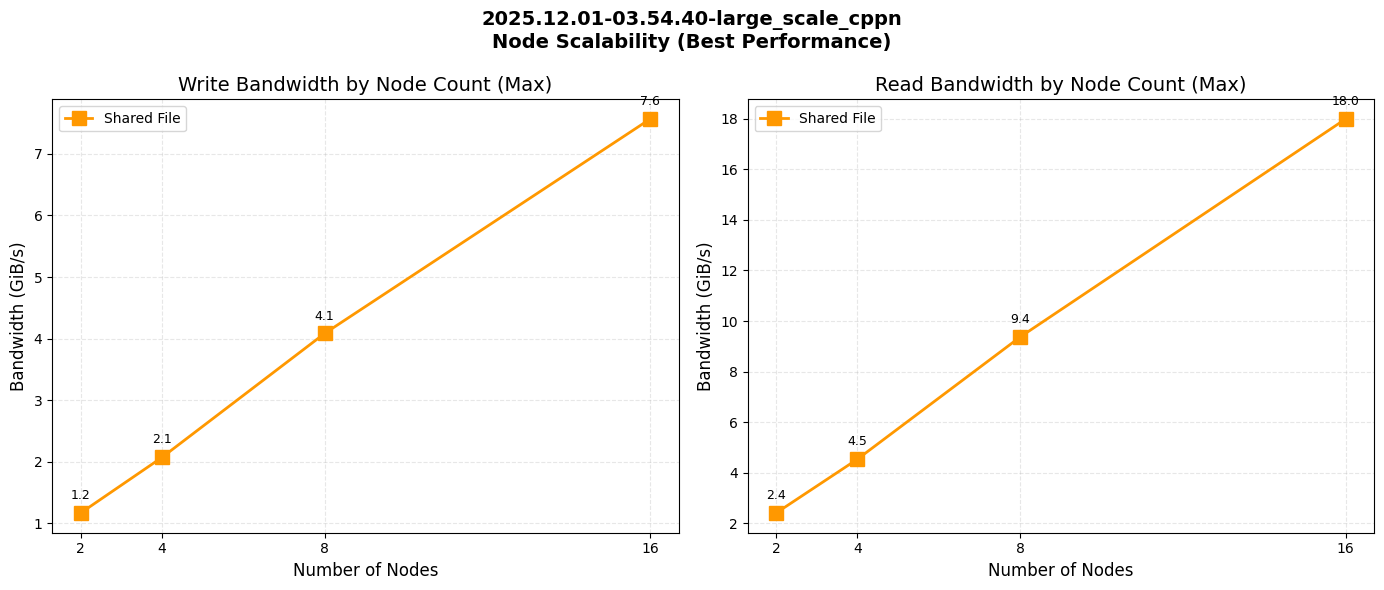

In [8]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Use nnodes from job_metadata (loaded from Miyabi output)
    node_counts = sorted(exp_df["nnodes"].unique().drop_nulls().to_list())
    print(f"Node counts in experiment: {node_counts}")
    
    if len(node_counts) < 2:
        print("Need at least 2 different node counts for comparison.")
    else:
        # Group by node count and operation - use MAX to get best performance across all parameter combinations
        node_bw = (
            exp_df
            .group_by(["nnodes", "operation", "access_mode"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
                pl.len().alias("samples"),
            ])
            .sort("nnodes")
        ).to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
        markers = {'File-per-Process': 'o', 'Shared File': 's'}
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = node_bw[node_bw['operation'] == operation]
            
            for mode in ['File-per-Process', 'Shared File']:
                mode_df = op_df[op_df['access_mode'] == mode]
                if mode_df.empty:
                    continue
                    
                ax.plot(
                    mode_df['nnodes'],
                    mode_df['bw_gib_max'],
                    marker=markers[mode],
                    markersize=10,
                    linewidth=2,
                    label=mode,
                    color=colors[mode],
                )
                
                # Add data labels
                for _, row in mode_df.iterrows():
                    ax.annotate(
                        f"{row['bw_gib_max']:.1f}",
                        (row['nnodes'], row['bw_gib_max']),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center',
                        fontsize=9,
                    )
            
            ax.set_xlabel('Number of Nodes')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth by Node Count (Max)')
            ax.legend(loc='upper left')
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xticks(node_counts)
        
        fig.suptitle(f'{experiment_label}\nNode Scalability (Best Performance)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"node_scalability_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

## Client PPN Comparison

クライアント側のPPN (processes per node) による帯域の違いを比較します。

Client PPN values: [4, 8, 16, 32]


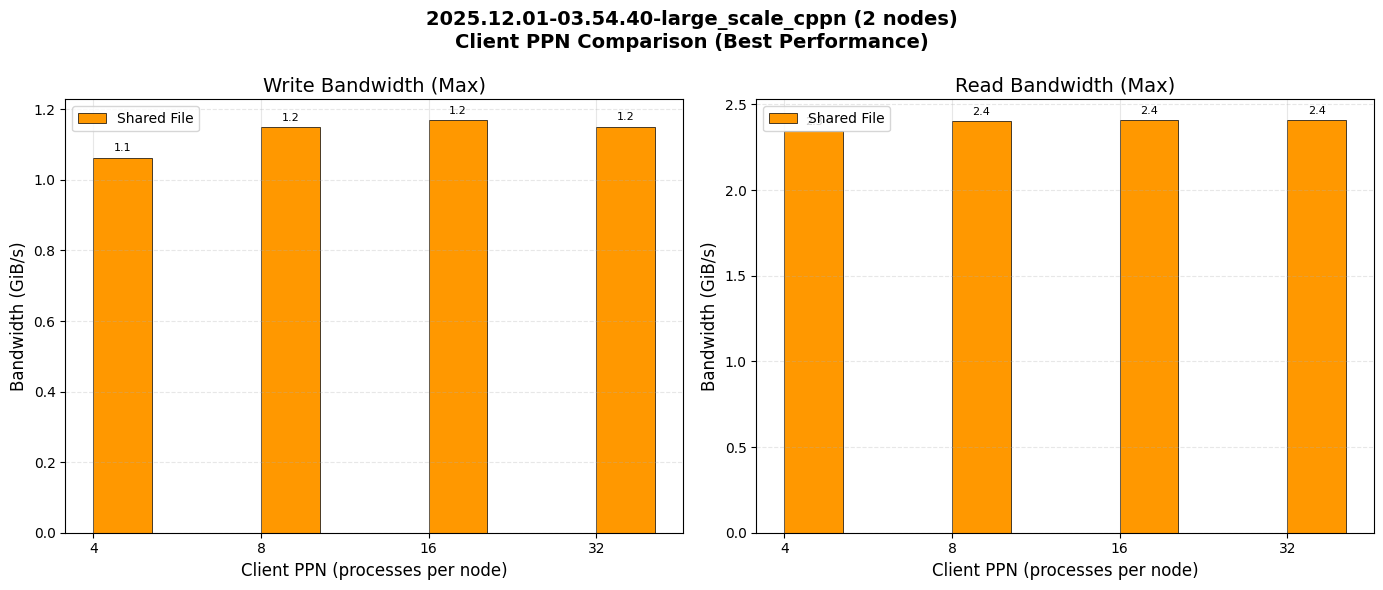

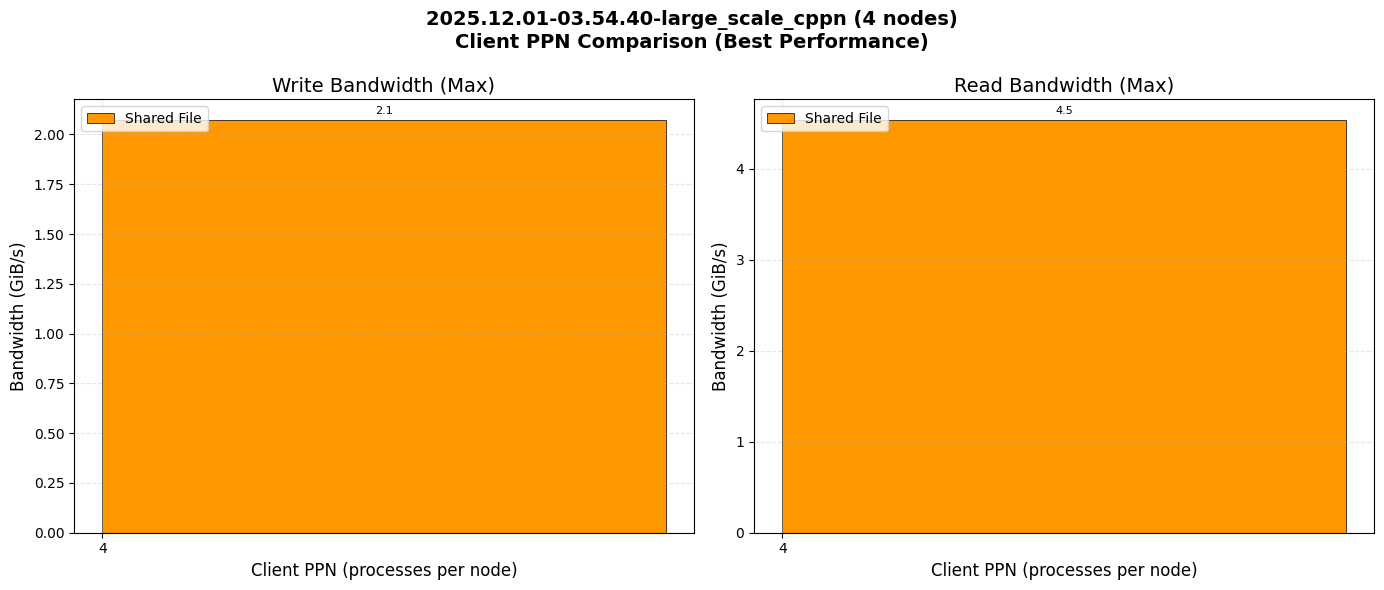

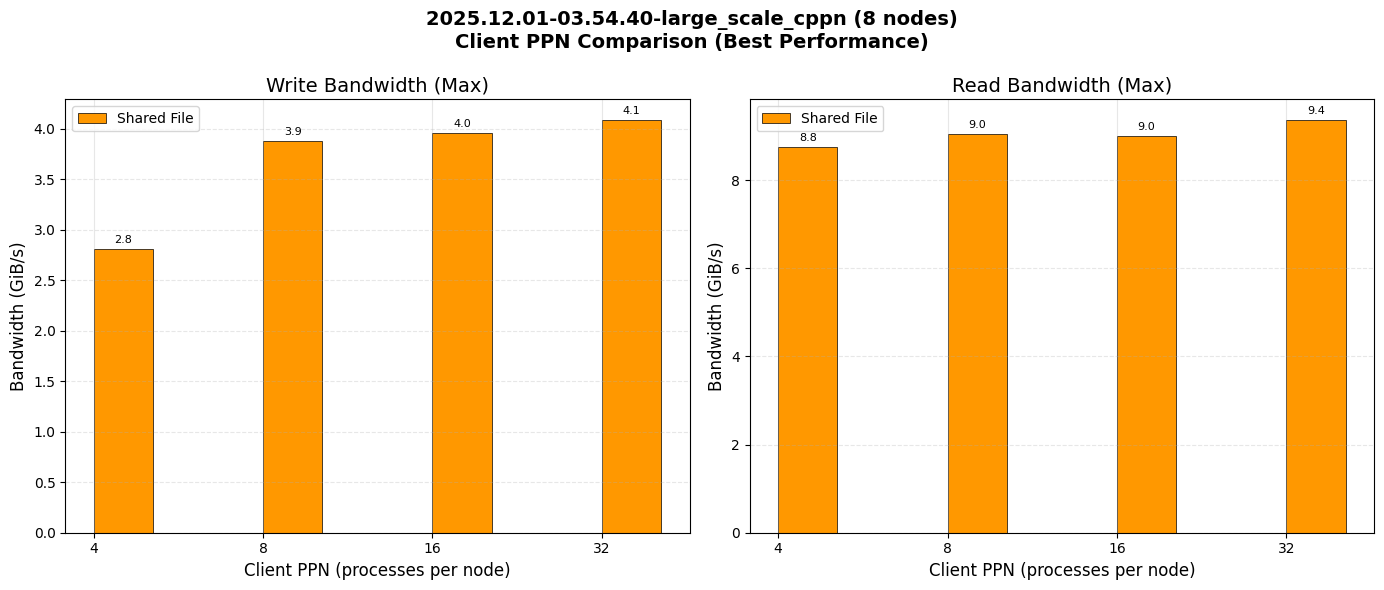

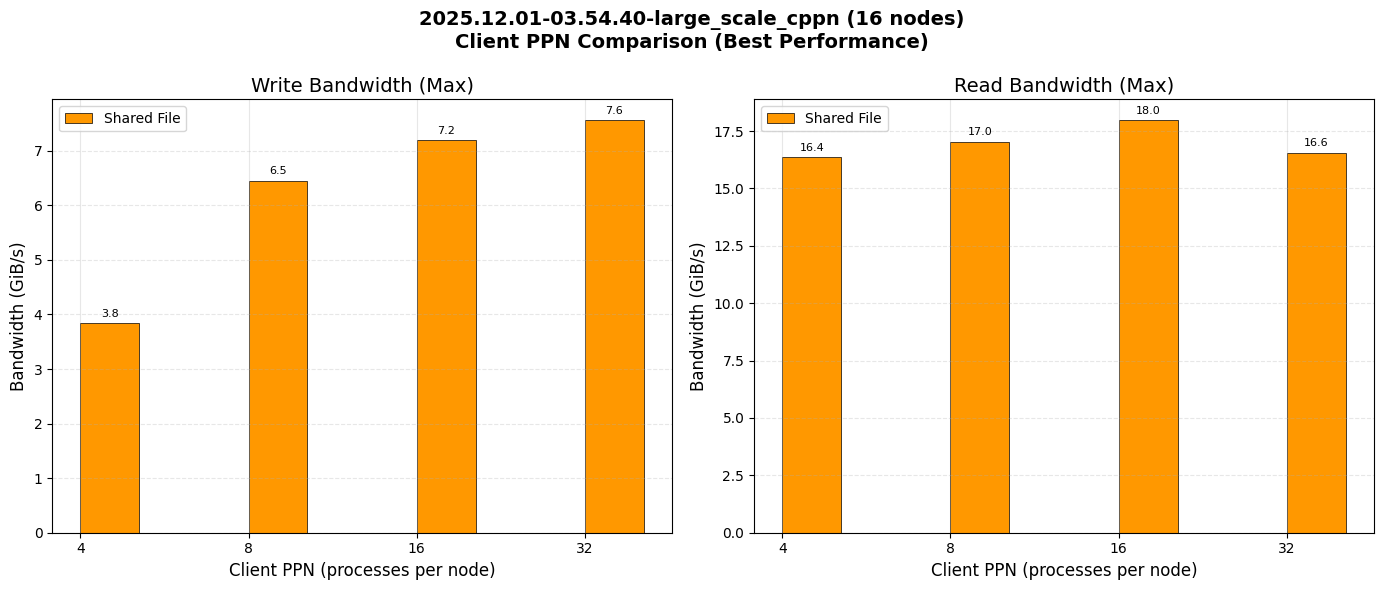

In [9]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Use client_ppn from job_metadata
    ppn_values = sorted(exp_df["client_ppn"].unique().drop_nulls().to_list())
    print(f"Client PPN values: {ppn_values}")
    
    if len(ppn_values) < 2:
        print("Need at least 2 different client PPN values for comparison.")
    else:
        # Group by client_ppn and operation - use MAX to get best performance
        ppn_bw = (
            exp_df
            .group_by(["client_ppn", "operation", "access_mode", "nnodes"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
                pl.col("num_tasks").first().alias("num_tasks"),
            ])
            .sort("client_ppn")
        ).to_pandas()
        
        # Plot for each node count
        node_counts = sorted(ppn_bw['nnodes'].dropna().unique())
        
        for nnodes in node_counts:
            node_df = ppn_bw[ppn_bw['nnodes'] == nnodes]
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
            
            for ax, operation in zip(axes, ['write', 'read']):
                op_df = node_df[node_df['operation'] == operation]
                ppn_list = sorted(op_df['client_ppn'].unique())
                
                width = 0.35
                x = range(len(ppn_list))
                
                for i, mode in enumerate(['File-per-Process', 'Shared File']):
                    mode_df = op_df[op_df['access_mode'] == mode]
                    if mode_df.empty:
                        continue
                    mode_df = mode_df.set_index('client_ppn').reindex(ppn_list)
                    
                    offset = -width/2 if i == 0 else width/2
                    ax.bar(
                        [xi + offset for xi in x],
                        mode_df['bw_gib_max'].fillna(0),
                        width=width,
                        label=mode,
                        color=colors[mode],
                        edgecolor='black',
                        linewidth=0.5,
                    )
                
                ax.set_xlabel('Client PPN (processes per node)')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.set_xticks(x)
                ax.set_xticklabels([int(p) for p in ppn_list])
                ax.legend(loc='upper left')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                
                # Add value labels
                for container in ax.containers:
                    if hasattr(container, 'patches'):
                        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
            
            fig.suptitle(f'{experiment_label} ({int(nnodes)} nodes)\nClient PPN Comparison (Best Performance)', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"client_ppn_{slugify(experiment_label)}_{int(nnodes)}nodes")
            plt.show()
            plt.close(fig)

## Server PPN Comparison

サーバー側のPPN (benchfsd processes per node) による帯域の違いを比較します。

In [10]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Use server_ppn from job_metadata
    server_ppn_values = sorted(exp_df["server_ppn"].unique().drop_nulls().to_list())
    print(f"Server PPN values: {server_ppn_values}")
    
    if len(server_ppn_values) < 2:
        print("Need at least 2 different server PPN values for comparison.")
    else:
        # Group by server_ppn and operation - use MAX to get best performance
        server_ppn_bw = (
            exp_df
            .group_by(["server_ppn", "operation", "access_mode", "nnodes"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
            ])
            .sort("server_ppn")
        ).to_pandas()
        
        # Plot for each node count
        node_counts = sorted(server_ppn_bw['nnodes'].dropna().unique())
        
        for nnodes in node_counts:
            node_df = server_ppn_bw[server_ppn_bw['nnodes'] == nnodes]
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
            
            for ax, operation in zip(axes, ['write', 'read']):
                op_df = node_df[node_df['operation'] == operation]
                ppn_list = sorted(op_df['server_ppn'].unique())
                
                width = 0.35
                x = range(len(ppn_list))
                
                for i, mode in enumerate(['File-per-Process', 'Shared File']):
                    mode_df = op_df[op_df['access_mode'] == mode]
                    if mode_df.empty:
                        continue
                    mode_df = mode_df.set_index('server_ppn').reindex(ppn_list)
                    
                    offset = -width/2 if i == 0 else width/2
                    ax.bar(
                        [xi + offset for xi in x],
                        mode_df['bw_gib_max'].fillna(0),
                        width=width,
                        label=mode,
                        color=colors[mode],
                        edgecolor='black',
                        linewidth=0.5,
                    )
                
                ax.set_xlabel('Server PPN (benchfsd per node)')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.set_xticks(x)
                ax.set_xticklabels([int(p) for p in ppn_list])
                ax.legend(loc='upper left')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                
                # Add value labels
                for container in ax.containers:
                    if hasattr(container, 'patches'):
                        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
            
            fig.suptitle(f'{experiment_label} ({int(nnodes)} nodes)\nServer PPN Comparison (Best Performance)', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"server_ppn_{slugify(experiment_label)}_{int(nnodes)}nodes")
            plt.show()
            plt.close(fig)

Server PPN values: [1]
Need at least 2 different server PPN values for comparison.


## Heatmap: Nodes x Client PPN

ノード数とクライアントPPNの組み合わせによる帯域をヒートマップで可視化します。

/tmp/ipykernel_1895274/3458270965.py:27: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="bw_gib", index="nnodes", columns="client_ppn")


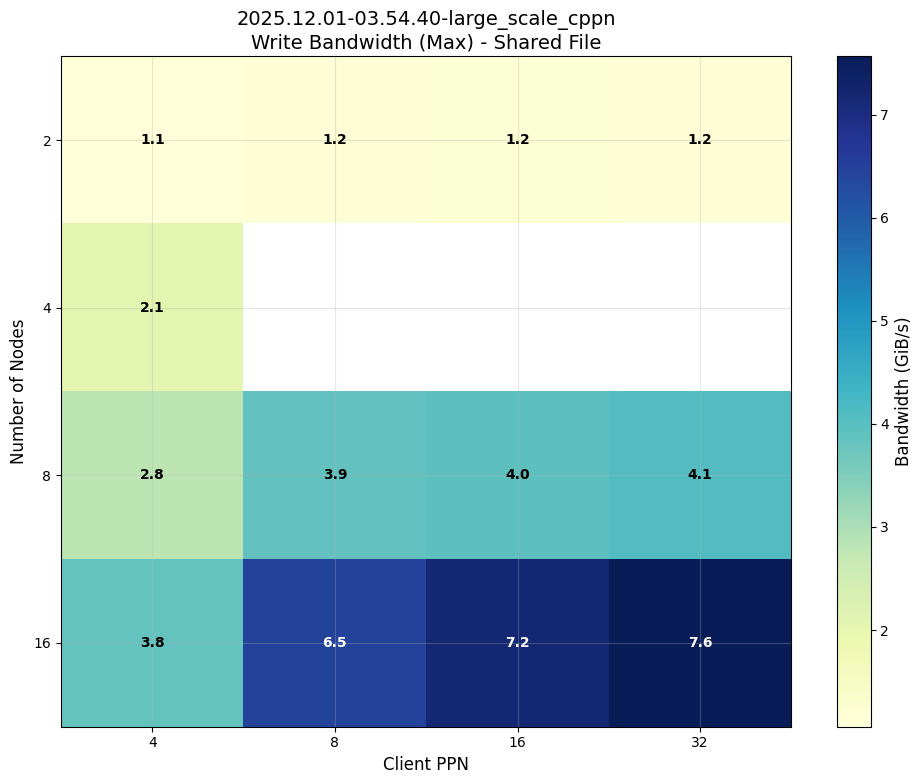

/tmp/ipykernel_1895274/3458270965.py:27: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="bw_gib", index="nnodes", columns="client_ppn")


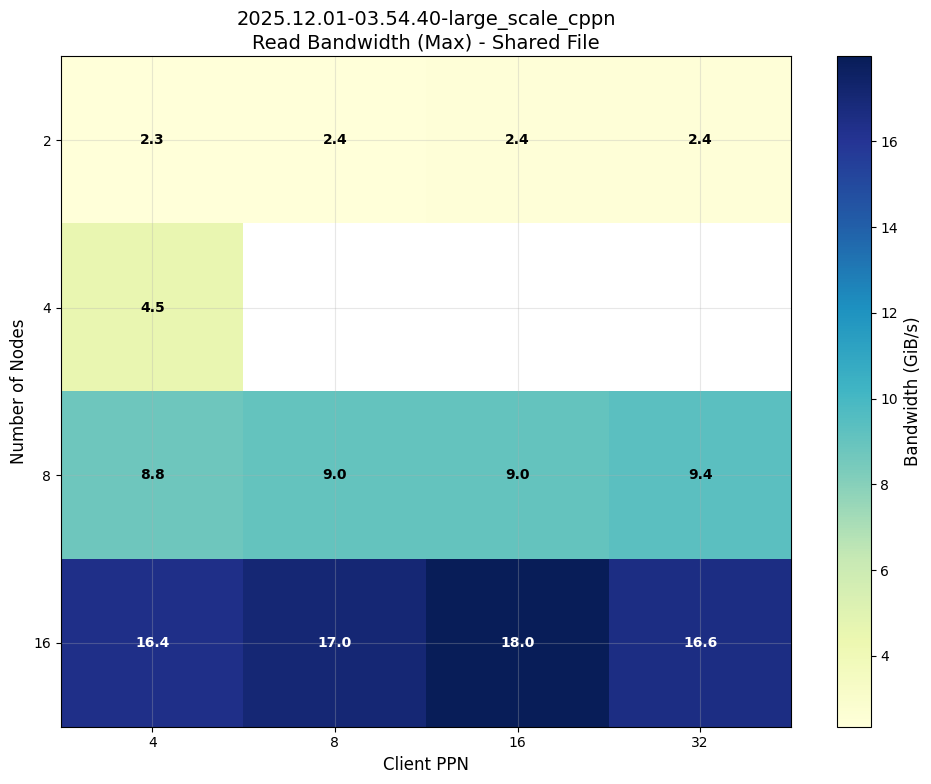

In [11]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    for access_mode in ['File-per-Process', 'Shared File']:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
        
        for operation in ['write', 'read']:
            op_df = mode_df.filter(pl.col("operation") == operation)
            if op_df.is_empty():
                continue
            
            # Create pivot table: nodes x client_ppn - use MAX
            pivot = (
                op_df
                .group_by(["nnodes", "client_ppn"])
                .agg(pl.col("bw_gib").max().alias("bw_gib"))
                .pivot(values="bw_gib", index="nnodes", columns="client_ppn")
                .sort("nnodes")
            ).to_pandas().set_index("nnodes")
            
            if pivot.empty or pivot.shape[0] < 2 or pivot.shape[1] < 2:
                continue
            
            # Sort columns numerically
            pivot = pivot.reindex(sorted(pivot.columns, key=lambda x: int(x) if str(x).isdigit() else 0), axis=1)
            
            fig, ax = plt.subplots(figsize=(10, 8))
            
            im = ax.imshow(pivot.values, cmap='YlGnBu', aspect='auto')
            
            ax.set_xticks(range(len(pivot.columns)))
            ax.set_xticklabels([int(c) for c in pivot.columns])
            ax.set_yticks(range(len(pivot.index)))
            ax.set_yticklabels([int(i) for i in pivot.index])
            
            ax.set_xlabel('Client PPN')
            ax.set_ylabel('Number of Nodes')
            ax.set_title(f'{experiment_label}\n{operation.capitalize()} Bandwidth (Max) - {access_mode}')
            
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Bandwidth (GiB/s)')
            
            # Add text annotations
            for i in range(len(pivot.index)):
                for j in range(len(pivot.columns)):
                    val = pivot.iloc[i, j]
                    if pd.notna(val):
                        text_color = 'white' if val > pivot.values[~pd.isna(pivot.values)].max() * 0.6 else 'black'
                        ax.text(j, i, f'{val:.1f}', ha='center', va='center', 
                               color=text_color, fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            save(fig, f"heatmap_{operation}_{slugify(access_mode)}_{slugify(experiment_label)}")
            plt.show()
            plt.close(fig)

## Bandwidth by Block Size

ブロックサイズ別のRead/Write帯域を比較します。

/tmp/ipykernel_1895274/1563137739.py:28: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_df = grouped.pivot(


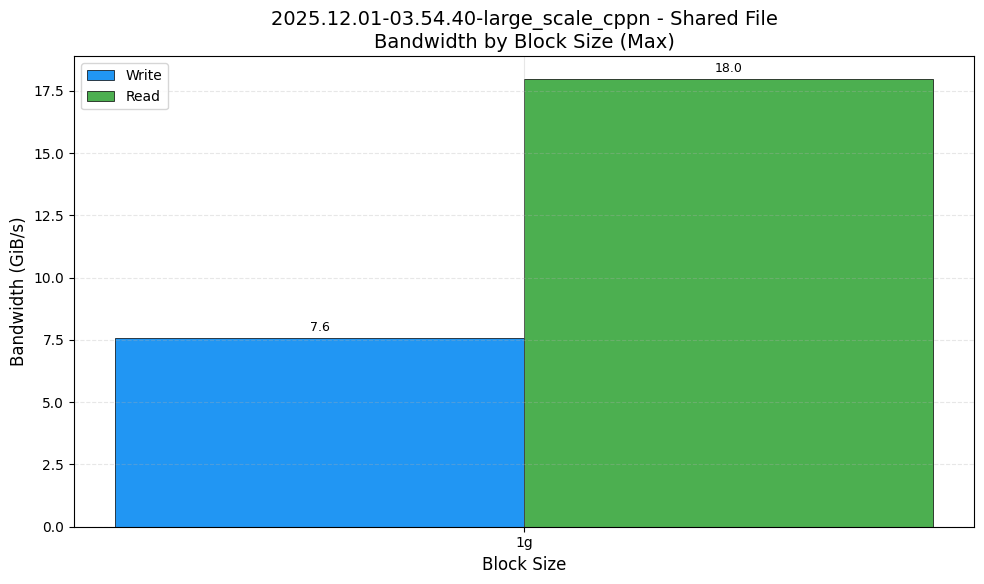

In [12]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    for access_mode in ["File-per-Process", "Shared File"]:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
            
        # Group by block size and operation - use MAX to get best performance
        grouped = (
            mode_df
            .group_by(["block_size_str", "operation"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
            ])
            .sort("block_size_str")
        )
        
        # Pivot for plotting
        pivot_df = grouped.pivot(
            values="bw_gib_max",
            index="block_size_str",
            columns="operation"
        ).to_pandas().set_index("block_size_str")
        
        # Sort by block size
        size_order = ['64m', '256m', '512m', '1g', '2g', '4g']
        pivot_df = pivot_df.reindex([s for s in size_order if s in pivot_df.index])
        
        if pivot_df.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(pivot_df))
        width = 0.35
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        if 'write' in pivot_df.columns:
            ax.bar([i - width/2 for i in x], pivot_df['write'], width, 
                   label='Write', color=colors['write'], edgecolor='black', linewidth=0.5)
        if 'read' in pivot_df.columns:
            ax.bar([i + width/2 for i in x], pivot_df['read'], width,
                   label='Read', color=colors['read'], edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Block Size')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'{experiment_label} - {access_mode}\nBandwidth by Block Size (Max)')
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_df.index)
        ax.legend(loc='upper left')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.1f', padding=3, fontsize=9)
        
        plt.tight_layout()
        save(fig, f"bandwidth_by_blocksize_{slugify(experiment_label)}_{slugify(access_mode)}")
        plt.show()
        plt.close(fig)

## Scalability Analysis

ノード数・プロセス数に対するスケーラビリティを確認します。

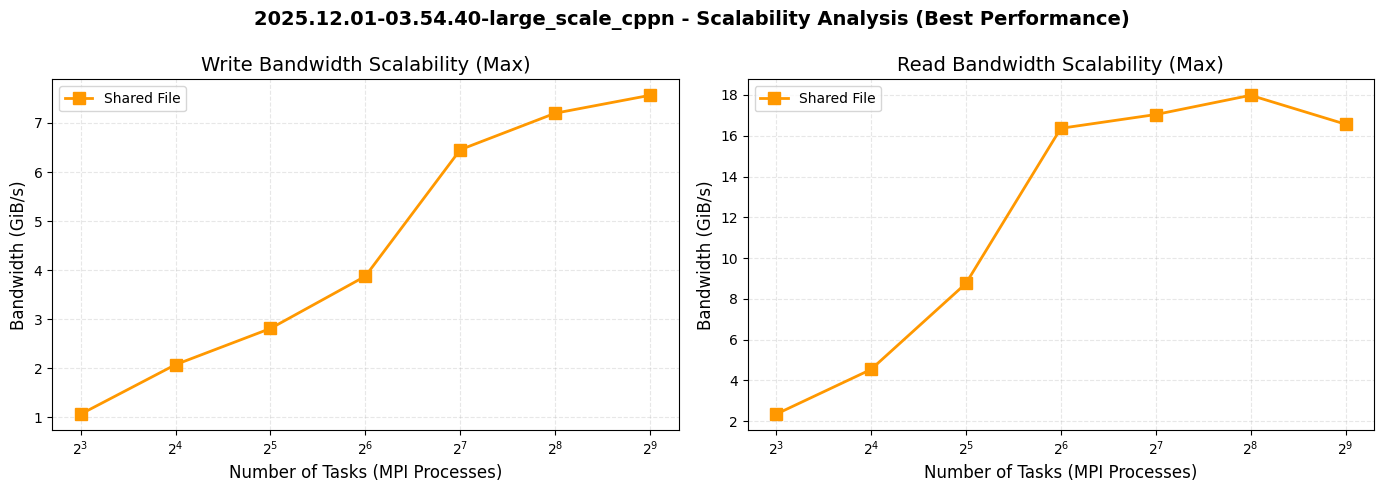

In [13]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    # Handle both single and multiple experiments
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    # Group by num_tasks and operation - use MAX to get best performance
    scalability = (
        exp_df
        .group_by(["num_tasks", "operation", "access_mode"])
        .agg([
            pl.col("bw_gib").max().alias("bw_gib_max"),
            pl.col("nnodes").first().alias("nodes"),
        ])
        .sort("num_tasks")
    )
    
    if scalability.is_empty():
        print("No scalability data available.")
    else:
        pdf = scalability.to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = pdf[pdf['operation'] == operation]
            
            for access_mode, marker, color in [('File-per-Process', 'o', '#2196F3'), ('Shared File', 's', '#FF9800')]:
                mode_df = op_df[op_df['access_mode'] == access_mode]
                if mode_df.empty:
                    continue
                ax.plot(
                    mode_df['num_tasks'],
                    mode_df['bw_gib_max'],
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                    label=access_mode,
                    color=color,
                )
            
            ax.set_xlabel('Number of Tasks (MPI Processes)')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth Scalability (Max)')
            ax.legend()
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xscale('log', base=2)
        
        fig.suptitle(f'{experiment_label} - Scalability Analysis (Best Performance)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"scalability_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

## Summary Statistics Table

実験の統計サマリを表形式で表示します。

In [14]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data available.")
else:
    exp_df = filtered_detail_df
    
    stats = (
        exp_df
        .group_by(["experiment", "nnodes", "access_mode", "operation", "block_size_str"])
        .agg([
            pl.col("bw_gib").mean().round(2).alias("Mean (GiB/s)"),
            pl.col("bw_gib").max().round(2).alias("Max (GiB/s)"),
            pl.col("bw_gib").min().round(2).alias("Min (GiB/s)"),
            pl.col("bw_gib").std().round(2).alias("Std (GiB/s)"),
            pl.len().alias("Samples"),
        ])
        .sort(["experiment", "nnodes", "access_mode", "operation", "block_size_str"])
    )
    
    experiment_label = SELECTED_EXPERIMENTS[0] if len(SELECTED_EXPERIMENTS) == 1 else f"{len(SELECTED_EXPERIMENTS)} experiments"
    print(f"\n{experiment_label} - Summary Statistics\n")
    display(stats.to_pandas())


2025.12.01-03.54.40-large_scale_cppn - Summary Statistics



,experiment,nnodes,access_mode,operation,block_size_str,Mean (GiB/s),Max (GiB/s),Min (GiB/s),Std (GiB/s),Samples
0,2025.12.01-03.54.40-large_scale_cppn,2,Shared File,read,1g,2.39,2.41,2.35,0.03,4
1,2025.12.01-03.54.40-large_scale_cppn,2,Shared File,write,1g,1.13,1.17,1.06,0.05,4
2,2025.12.01-03.54.40-large_scale_cppn,4,Shared File,read,1g,4.54,4.54,4.54,NaN,1
3,2025.12.01-03.54.40-large_scale_cppn,4,Shared File,write,1g,2.07,2.07,2.07,NaN,1
4,2025.12.01-03.54.40-large_scale_cppn,8,Shared File,read,1g,9.04,9.37,8.76,0.25,4
5,2025.12.01-03.54.40-large_scale_cppn,8,Shared File,write,1g,3.68,4.08,2.81,0.59,4
6,2025.12.01-03.54.40-large_scale_cppn,16,Shared File,read,1g,16.99,17.99,16.37,0.72,4
7,2025.12.01-03.54.40-large_scale_cppn,16,Shared File,write,1g,6.27,7.56,3.84,1.68,4


## Export Processed Data

整形済みのサマリと詳細データをJSONとして保存します。

In [15]:
if filtered_summary_df.is_empty() and filtered_detail_df.is_empty():
    print("No IOR results to export.")
else:
    experiment_suffix = "_".join(slugify(e) for e in SELECTED_EXPERIMENTS) if SELECTED_EXPERIMENTS else "all"
    
    if not filtered_summary_df.is_empty():
        summary_out = DATA_DIR / f"ior_summary_{experiment_suffix}.json"
        summary_out.parent.mkdir(parents=True, exist_ok=True)
        summary_out.write_text(
            json.dumps(filtered_summary_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {summary_out}")
    else:
        print("No summary records to export.")
        
    if not filtered_detail_df.is_empty():
        detail_out = DATA_DIR / f"ior_detail_{experiment_suffix}.json"
        detail_out.parent.mkdir(parents=True, exist_ok=True)
        detail_out.write_text(
            json.dumps(filtered_detail_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {detail_out}")
    else:
        print("No detailed records to export.")

Wrote /work/xg24i002/x10043/workspace/rust/benchfs/plot/processed/benchfsd/ior_summary_2025.12.01-03.54.40-large_scale_cppn.json
Wrote /work/xg24i002/x10043/workspace/rust/benchfs/plot/processed/benchfsd/ior_detail_2025.12.01-03.54.40-large_scale_cppn.json
